In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Embedding, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
url = '/content/drive/MyDrive/datasets/seg_plus_pos_mgr.txt'
data = pd.read_csv(url, sep='\t')
data.head()

,Fold,SubFold,SentID,Order,Word,Segmentation,POS
0,2,B,1,1,0.7,0.7,NUM
1,2,B,1,2,ديال,ديال,PREP
2,2,B,1,3,المغربيات,ال+مغربي+ات,DET+NOUN+NSUFF
3,2,B,1,4,لي,لي,PART
4,2,B,1,5,خدامات,خدام+ات,V+PRON


In [ ]:
def extract_unique_pos(POS):
    unique_pos = set()
    for pos_string in POS:
        tags = pos_string.split('+')
        unique_pos.update([tag.lower() for tag in tags])
    return unique_pos

In [ ]:
labels = np.array(list(extract_unique_pos(data['POS'])), dtype=str)
label_mapping = {label: index for index, label in enumerate(labels)}
labels

array(['eos', 'prog_part', 'adj', 'url', 'v', 'punc', 'prep', 'conj',
       'foreign', 'emot', 'mention', 'fut_part', 'noun', 'hash',
       'neg_part', 'part', 'num', 'adv', 'det', 'case', 'nsuff', 'pron'],
      dtype='<U9')

In [ ]:
def one_hot_encode_pos(pos_string, label_mapping, labels):
    one_hot_vector = np.zeros(len(labels), dtype=float)
    for pos in pos_string.split('+'):
        index = label_mapping[pos.lower()]
        if index is not None:
            one_hot_vector[index] = 1.0
    return one_hot_vector

In [ ]:
data['POS_One_Hot'] = data['POS'].apply(lambda x: one_hot_encode_pos(x, label_mapping, labels))
data

,Fold,SubFold,SentID,Order,Word,Segmentation,POS,POS_One_Hot
0,2,B,1,1,0.7,0.7,NUM,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,B,1,2,ديال,ديال,PREP,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,2,B,1,3,المغربيات,ال+مغربي+ات,DET+NOUN+NSUFF,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,B,1,4,لي,لي,PART,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,B,1,5,خدامات,خدام+ات,V+PRON,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
6745,4,B,350,15,عليوتيوب,ع+ال+يوتيوب,PREP+DET+NOUN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
6746,4,B,350,16,رتويت,رتويت,V,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
6747,4,B,350,17,بليز,بليز,NOUN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6748,4,B,350,18,#ماكو_س,#ماكو_س,HASH,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
num_class = len(labels)
print(f'Nuber of Classes = {num_class}')

Nuber of Classes = 22


In [ ]:
max_length = data.groupby('SentID').count()['Word'].max()
print(f'Max Lenght = {max_length}')

Max Lenght = 32


In [ ]:
num_sentence = len(pd.unique(data['SentID']))
print(f'Number of Sentence = {num_sentence}')

Number of Sentence = 350


In [ ]:
Tokens = data.groupby('SentID')['Word'].agg(lambda x: x.tolist())

Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(Tokens)

X = pad_sequences(Tokenizer.texts_to_sequences(Tokens), maxlen = max_length, padding='post', truncating='post')

In [ ]:
vocab_size = len(Tokenizer.word_index) + 1
print(f'Vocabulary Size = {vocab_size}')

Vocabulary Size = 3311


In [ ]:
Tags = data.groupby('SentID')['POS_One_Hot'].agg(lambda x: x.tolist())

y = pad_sequences(Tags, maxlen = max_length, padding='post', truncating='post')

In [ ]:
print(f'Input Shape: {X.shape}')
print(f'Output Shape: {y.shape}')

Input Shape: (350, 32)
Output Shape: (350, 32, 22)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(f'train Input Shape: {X_train.shape}')
print(f'train Output Shape: {y_train.shape}')
print()
print(f'test Input Shape: {X_test.shape}')
print(f'test Output Shape: {y_test.shape}')

train Input Shape: (280, 32)
train Output Shape: (280, 32, 22)

test Input Shape: (70, 32)
test Output Shape: (70, 32, 22)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_class, activation='sigmoid'),
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 100)           331100    
                                                                 
 bidirectional_4 (Bidirecti  (None, 32, 128)           84480     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32, 64)            49408     
                                                                 
 dropout_5 (Dropout)         (None, 32, 64)            0         
                                                                 
 dense_4 (Dense)             (None, 32, 22)            1430      
                                                      

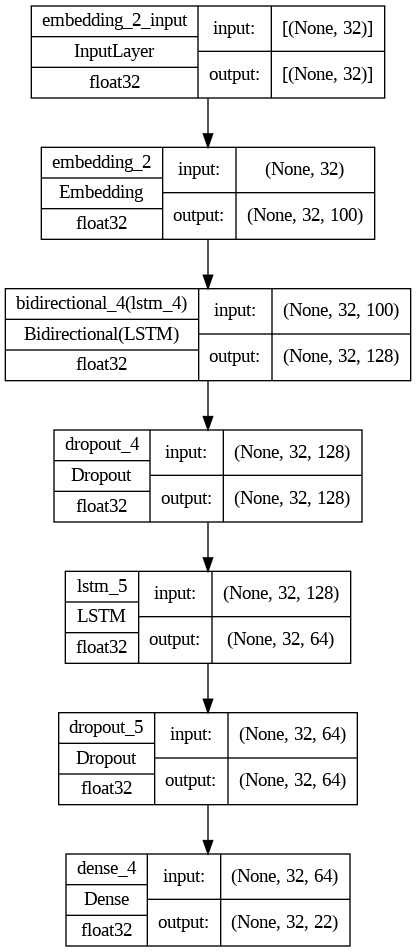

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
LR = 1e-3
BATCH_SIZE = 8
EPOCHS = 100

checkpoint_lstm = tf.keras.callbacks.ModelCheckpoint(
    'POS_TAGGING_Model.h5',
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[checkpoint_lstm])

Epoch 1/100
28/28 [==============================] - 8s 102ms/step - loss: 0.4388 - accuracy: 0.1650 - val_loss: 0.1773 - val_accuracy: 0.2662
Epoch 2/100
28/28 [==============================] - 2s 75ms/step - loss: 0.1674 - accuracy: 0.1649 - val_loss: 0.1491 - val_accuracy: 0.1830
Epoch 3/100
28/28 [==============================] - 2s 73ms/step - loss: 0.1537 - accuracy: 0.1244 - val_loss: 0.1443 - val_accuracy: 0.1830
Epoch 4/100
28/28 [==============================] - 2s 69ms/step - loss: 0.1495 - accuracy: 0.1317 - val_loss: 0.1410 - val_accuracy: 0.1830
Epoch 5/100
28/28 [==============================] - 1s 49ms/step - loss: 0.1442 - accuracy: 0.1461 - val_loss: 0.1375 - val_accuracy: 0.1830
Epoch 6/100
28/28 [==============================] - 1s 44ms/step - loss: 0.1408 - accuracy: 0.1614 - val_loss: 0.1347 - val_accuracy: 0.1830
Epoch 7/100
28/28 [==============================] - 1s 48ms/step - loss: 0.1369 - accuracy: 0.1779 - val_loss: 0.1327 - val_accuracy: 0.1830
Epoch

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

3/3 [==============================] - 2s 29ms/step - loss: 0.1105 - accuracy: 0.8165
Loss: 0.11049320548772812, Accuracy: 0.8165178298950195


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

3/3 [==============================] - 2s 27ms/step


In [ ]:
# Confusion Matrix for each class
for i in range(num_class):
    print(f"Classification Report for Class {labels[i]}:\n", classification_report(y_test[..., i].reshape(-1), y_pred[..., i].reshape(-1), zero_division=0.0), "\n")

Classification Report for Class eos:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2170
           1       1.00      1.00      1.00        70

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      2240
 

Classification Report for Class prog_part:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2234
           1       0.00      0.00      0.00         6

    accuracy                           1.00      2240
   macro avg       0.50      0.50      0.50      2240
weighted avg       0.99      1.00      1.00      2240
 

Classification Report for Class adj:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2195
           1       0.62      0.11      0.19        45

    accuracy                           0.98      2240
   m